In [1]:
import os
import sys
module_path = os.path.abspath(os.path.join('../'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
import pandas as pd
from tqdm import tqdm

In [2]:
os.environ['CUDA_VISIBLE_DEVICES']=''

In [3]:
import matplotlib.pyplot as plt

import torch
import torch.optim as optim
import numpy as np

%matplotlib inline
%load_ext autoreload
%autoreload 2

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
import os
import sys
module_path = os.path.abspath(os.path.join('../'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
import pandas as pd
from tqdm import tqdm

import matplotlib.pyplot as plt

import torch
import torch.optim as optim
import numpy as np

template_data_path = "/network/lustre/iss02/aramis/datasets/adni/caps/caps_v2021/subjects/sub-ADNI002S0295/ses-M00/deeplearning_prepare_data/image_based/t1_linear/sub-ADNI002S0295_ses-M00_T1w_space-MNI152NLin2009cSym_desc-Crop_res-1x1x1_T1w.pt"
template_data = torch.load(template_data_path)
template_data = template_data[:,4:164:2,8:200:2,8:168:2]

caps_info = pd.read_csv('/network/lustre/iss02/aramis/datasets/adni/caps/caps_v2021.tsv', sep='\t', 
                        error_bad_lines=False)[['participant_id', 'session_id', 'age', 'diagnosis', 'MMSE']].set_index(['participant_id','session_id'])

path_imaging_data = "/network/lustre/iss02/aramis/datasets/adni/caps/caps_v2021/subjects/"

sub_lst = sorted(os.listdir(path_imaging_data))
data_dict = {'data':torch.tensor(template_data), 'timepoints':torch.ones(1), 'labels':torch.IntTensor([1])}

number_of_patients = 3000
i = 0 

data_lst, timepoints_lst, labels_lst = [], [], []

for sub in tqdm(sub_lst):
    
    if i == number_of_patients:
        break
        
    sub_id = sub[12:]
    sub_path = path_imaging_data+sub
    ses_lst = sorted(os.listdir(sub_path))
    
    i += 1
    for ses in ses_lst:
        ses_path = os.path.join(sub_path, ses)
        if 't1_linear' in os.listdir(ses_path):
            filename = 'deeplearning_prepare_data/image_based/t1_linear/' + sub + '_' + ses + '_T1w_space-MNI152NLin2009cSym_desc-Crop_res-1x1x1_T1w.pt'
            ses_data_path = os.path.join(ses_path, filename)

            #if (caps_info.loc[(sub,ses)]['diagnosis'] in ['CN']):
            #if 'AD' in caps_info.loc[sub].values:

            # Load the data
            ses_torch = torch.load(ses_data_path)
            if ses_torch.isnan().any() or torch.tensor([caps_info.loc[(sub,ses)]['age']]).isnan():
                continue
            # Subsample
            ses_torch = ses_torch[:,4:164:2,8:200:2,8:168:2]
            # Normalize
            ses_torch = ses_torch/ses_torch.max()

            data_lst.append(ses_torch.float())
            timepoints_lst.append(torch.tensor([caps_info.loc[(sub,ses)]['age']]))
            labels_lst.append(torch.tensor([int(sub_id)]))
            
            #data_dict['data'] = torch.cat((data_dict['data'], ses_torch.float()))
            #data_dict['timepoints'] = torch.cat((data_dict['timepoints'], torch.tensor([caps_info.loc[(sub,ses)]['age']])))
            #data_dict['labels'] = torch.cat((data_dict['labels'], torch.tensor([int(sub_id)])))

# Threshold to have a lot of 0 values in the input
mask_threshold = data_dict['data']<(torch.tensor(3e-2))
data_dict['data'][mask_threshold] = 0
        
# Then add the (useless timepointss) and delete the template data
#data_dict['data'], data_dict['timepoints'], data_dict['labels'] = data_dict['data'][1:], data_dict['timepoints'][1:], data_dict['labels'][1:]

data_dict['data'] = torch.cat(data_lst)
data_dict['timepoints'] = torch.cat(timepoints_lst)
data_dict['labels'] = torch.cat(labels_lst)

already_seen = []
group = []
idx = -1

for i in range(len(data_dict['labels'])):
    if data_dict['labels'][i] not in already_seen:
        already_seen.append(data_dict['labels'][i])
        idx += 1
    group.append(idx)
    
data_dict['RID'] = data_dict['labels']
data_dict['labels'] = torch.tensor(group)

/home/benoit.sautydechalon/anaconda3/envs/deformetrica/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3169: DtypeWarning: Columns (117,118,119,310) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
/tmp/ipykernel_7966/2542000338.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data_dict = {'data':torch.tensor(template_data), 'timepoints':torch.ones(1), 'labels':torch.IntTensor([1])}
100%|█████████████████████████████████████| 2254/2254 [1:16:27<00:00,  2.04s/it]


In [5]:
torch.save(data_dict, '/network/lustre/iss02/aramis/users/benoit.sautydechalon/miccai_2022/ADNI_t1')

# MRI

## Loading the tensors

In [65]:
template_data_path = "/network/lustre/iss02/aramis/datasets/adni/caps/caps_v2021/subjects/sub-ADNI002S0295/ses-M00/deeplearning_prepare_data/image_based/t1_linear/sub-ADNI002S0295_ses-M00_T1w_space-MNI152NLin2009cSym_desc-Crop_res-1x1x1_T1w.pt"
template_data = torch.load(template_data_path)
#template_data = template_data[:,::2,::2,::2]

In [66]:
template_data = template_data[:,4:164:2,8:200:2,8:168:2]
template_data.shape

torch.Size([1, 80, 96, 80])

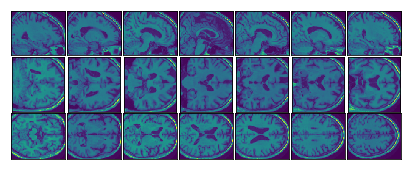

In [53]:
fig, axes = plt.subplots(3,7, figsize=(7,2.75), gridspec_kw={'height_ratios':[.8,.96,.8]})
plt.subplots_adjust(wspace=0.03, hspace=0.02)

for i in range(7):
    axes[2][i].matshow(template_data[0][:,:,20 + 5*i])
    axes[1][i].matshow(template_data[0][:,20 + 5*i])
    axes[0][i].matshow(np.rot90(template_data[0][20 + 5*i]))
    
for axe in axes:
    for ax in axe:
        ax.set_xticks([])
        ax.set_yticks([])

#plt.matshow(template_data[0][:,:,40])
plt.show()

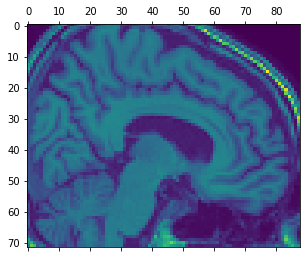

In [54]:
plt.matshow(np.rot90(template_data[0][40]))
plt.show()

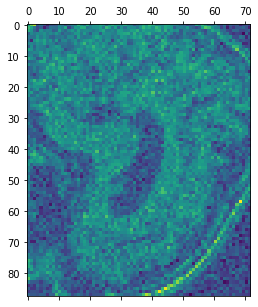

In [55]:
# Illustraion of the noise added to the discriminator

template_data /= template_data.max()
plt.matshow(template_data[0][30] + torch.normal(torch.zeros(template_data[0][30].shape), 0.1))
plt.show()

In [59]:
caps_info = pd.read_csv('/network/lustre/iss02/aramis/datasets/adni/caps/caps_v2021.tsv', sep='\t', 
                        error_bad_lines=False)[['participant_id', 'session_id', 'age', 'diagnosis', 'MMSE']].set_index(['participant_id','session_id'])

In [67]:
path_imaging_data = '/network/lustre/iss02/aramis/datasets/adni/caps/caps_v2021/subjects/'

sub_lst = sorted(os.listdir(path_imaging_data))
data_dict = {'data':torch.tensor(template_data), 'timepoints':torch.ones(1), 'labels':torch.IntTensor([1])}

number_of_patients = 3000
i = 0 

for sub in tqdm(sub_lst):
    
    if i == number_of_patients:
        break
        
    sub_id = sub[12:]
    sub_path = path_imaging_data+sub
    ses_lst = sorted(os.listdir(sub_path))
    
    #if caps_info.loc[sub]['MMSE'].between(5, 26).any():
    i += 1
    for ses in ses_lst:

        ses_path = os.path.join(sub_path, ses)
        filename = 'deeplearning_prepare_data/image_based/t1_linear/' + sub + '_' + ses + '_T1w_space-MNI152NLin2009cSym_desc-Crop_res-1x1x1_T1w.pt'
        ses_data_path = os.path.join(ses_path, filename)

        #if (caps_info.loc[(sub,ses)]['diagnosis'] in ['CN']):
        #if 'AD' in caps_info.loc[sub].values:
            #print(caps_info.loc[(sub,ses)]['diagnosis'])
            # Load the data
        ses_torch = torch.load(ses_data_path)
        if ses_torch.isnan().any() or torch.tensor([caps_info.loc[(sub,ses)]['age']]).isnan():
            continue
        # Subsample
        ses_torch = ses_torch[:,4:164:2,8:200:2,8:168:2]
        # Normalize
        #ses_torch = ses_torch/ses_torch.max()
        quant = np.quantile(ses_torch, 0.97)
        ses_torch /= quant
        data_dict['data'] = torch.cat((data_dict['data'], ses_torch.float()))
        data_dict['timepoints'] = torch.cat((data_dict['timepoints'], torch.tensor([caps_info.loc[(sub,ses)]['age']])))
        data_dict['labels'] = torch.cat((data_dict['labels'], torch.tensor([int(sub_id)])))

# Threshold to have a lot of 0 values in the input
mask_threshold = data_dict['data']<(torch.tensor(1e-2))
data_dict['data'][mask_threshold] = 0
        
# Then add the (useless timepointss) and delete the template data
data_dict['data'], data_dict['timepoints'], data_dict['labels'] = data_dict['data'][1:], data_dict['timepoints'][1:], data_dict['labels'][1:]

data_dict

/tmp/ipykernel_472894/3319000073.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data_dict = {'data':torch.tensor(template_data), 'timepoints':torch.ones(1), 'labels':torch.IntTensor([1])}
 40%|███████████████████▋                             | 906/2254 [1:55:35<2:51:59,  7.66s/it]


KeyboardInterrupt: 

In [ ]:
print(f"There are {data_dict['data'].shape[0]} visits with a total of {data_dict['data'].shape[1]*data_dict['data'].shape[2]*data_dict['data'].shape[3]} dimentions")

In [ ]:
torch.save(data_dict, 'ADNI_t1')

### Remove the visits where timepoint is nan

In [29]:
data_dict = torch.load('ADNI_t1')

In [32]:
for i in range(len(data_dict['timepoints'])):
    if data_dict['timepoints'][i].isnan():
        print(i)

In [21]:
data_dict['timepoints'] = torch.cat([data_dict['timepoints'][:3606], data_dict['timepoints'][3607:5256], data_dict['timepoints'][5257:5346], data_dict['timepoints'][5348:7139], data_dict['timepoints'][7140:]])
data_dict['labels'] = torch.cat([data_dict['labels'][:3606], data_dict['labels'][3607:5256], data_dict['labels'][5257:5346], data_dict['labels'][5348:7139], data_dict['labels'][7140:]])
data_dict['data'] = torch.cat([data_dict['data'][:3606], data_dict['data'][3607:5256], data_dict['data'][5257:5346], data_dict['data'][5348:7139], data_dict['data'][7140:]])

In [22]:
for i in range(len(data_dict['timepoints'])):
    if data_dict['timepoints'][i].isnan():
        print(i)

In [8]:
torch.save(data_dict, 'ADNI_t1')

### Reorder the ids

In [46]:
data_dict = torch.load('ADNI_t1')

In [ ]:
already_seen = []
group = []
idx = -1

for i in range(len(data_dict['labels'])):
    if data_dict['labels'][i] not in already_seen:
        already_seen.append(data_dict['labels'][i])
        idx += 1
    group.append(idx)

In [ ]:
data_dict['RID'] = data_dict['labels']
data_dict['labels'] = torch.tensor(group)

In [ ]:
torch.save(data_dict, 'ADNI_t1')

In [24]:
data_dict = torch.load('ADNI_AD_norm')

In [26]:
data_dict['data'].shape

torch.Size([3685, 80, 96, 80])

In [30]:
data_dict['timepoints'].mean()

tensor(75.8696, dtype=torch.float64)

## Load the saved data and take only a subset to allow faster training

In [18]:
data = torch.load('ADNI_CN')

In [19]:
data['data'].shape

torch.Size([456, 80, 96, 80])

In [8]:
already_seen = []
index = []
i = -1

for sub in data['labels']:
    if sub in already_seen:
        index.append(i)
    else:
        i += 1
        already_seen.append(sub)
        index.append(i)
        
torch.tensor(index) 

tensor([  0,   0,   0,  ..., 940, 941, 941])

## Mini-dataset for debugging

In [77]:
mini_data = {}
mini_data['data'] = data['data'][:10]
mini_data['timepoints'] = [(index[i], float(data['timepoints'][i])) for i in range(10)]
mini_data['label'] = data['label'][:10]

In [79]:
torch.save(mini_data,'mini_dataset')

## Small-dataset for testing

In [80]:
mini_data = {}
mini_data['data'] = data['data'][:100]
mini_data['ADNI_id'] = data['label'][:100]
mini_data['timepoints'] = [(index[i], float(data['timepoints'][i])) for i in range(100)]
mini_data['label'] = data['label'][:100]

In [81]:
torch.save(mini_data,'small_dataset')

## Large dataset for training

In [82]:
mini_data = {}
mini_data['data'] = data['data']
mini_data['timepoints'] = [(index[i], float(data['timepoints'][i])) for i in range(len(data['data']))]
mini_data['label'] = data['label']

In [83]:
torch.save(mini_data,'large_dataset')

## Data-analysis on the encoded images

In [7]:
encoded = torch.load('../deformetrica/deformetrica/LAE_experiments/encoded_datasetCAE_300_epochs_5e-5_lr')

In [32]:
data = encoded['data']

In [11]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn import decomposition
from sklearn.preprocessing import scale
from sklearn.decomposition import PCA

In [28]:
data = scale(data)

In [27]:
data.mean()

tensor(0.5189)

In [33]:
covar_matrix = PCA(n_components = 20)

In [34]:
covar_matrix.fit(data)
variance = covar_matrix.explained_variance_ratio_ #calculate variance ratios

var=np.cumsum(np.round(covar_matrix.explained_variance_ratio_, decimals=3)*100)
var #cumulative sum of variance explained with [n] features


array([68.7, 72.7, 74.1, 75. , 75.6, 76.1, 76.6, 77. , 77.3, 77.6, 77.9,
       78.2, 78.5, 78.8, 79.1, 79.3, 79.5, 79.7, 79.9, 80.1])

## Data-analysis on the true images

In [45]:
data = torch.load('ADNI_CN')

(array([19., 25., 38., 73., 90., 70., 57., 41., 30., 13.]),
 array([55.1 , 58.71, 62.32, 65.93, 69.54, 73.15, 76.76, 80.37, 83.98,
        87.59, 91.2 ]),
 <BarContainer object of 10 artists>)

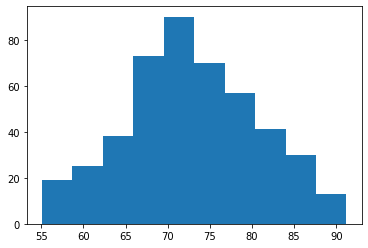

In [49]:
plt.hist(np.array(data['timepoints']))

In [50]:
data = torch.load('ADNI_MCI_AD')

(array([ 79., 181., 324., 594., 938., 988., 840., 488., 129.,   8.]),
 array([54.4 , 58.69, 62.98, 67.27, 71.56, 75.85, 80.14, 84.43, 88.72,
        93.01, 97.3 ]),
 <BarContainer object of 10 artists>)

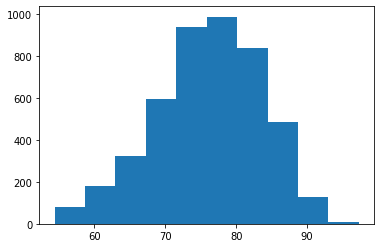

In [51]:
plt.hist(np.array(data['timepoints']))

In [28]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn import decomposition
from sklearn.preprocessing import scale
from sklearn.decomposition import PCA

In [33]:
data = (data-data.mean())/data.std()

In [34]:
covar_matrix = PCA(n_components = 20)

In [36]:
n_samples, nx, ny, nz = data.shape
data = data.reshape((n_samples, nx*ny*nz))

covar_matrix.fit(data)
variance = covar_matrix.explained_variance_ratio_ #calculate variance ratios

var=np.cumsum(np.round(covar_matrix.explained_variance_ratio_, decimals=3)*100)
var #cumulative sum of variance explained with [n] features

array([13.5, 19.2, 22.9, 24.8, 26.6, 28.2, 29.7, 30.9, 32. , 33.1, 34.1,
       35. , 35.7, 36.4, 37.1, 37.8, 38.4, 39. , 39.5, 40. ])

## Exploring the normalization issues

In [10]:
data_dict = torch.load('ADNI_MCI_AD')

In [11]:
data = data_dict['data']

In [12]:
means_ = []
std_ = []
max_ = []  
quant_ = []

n_scans = len(data)

for i in range(n_scans):
    img = data[i]
    mean, std, maximum = float(img.mean()), float(img.std()), float(img.max())
    quant = np.quantile(img, 0.96)
    means_.append(mean)
    std_.append(std)
    max_.append(maximum)
    quant_.append(quant)

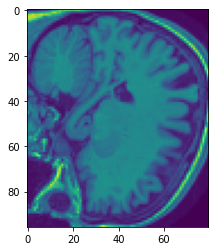

In [13]:
plt.imshow(data[254][28])

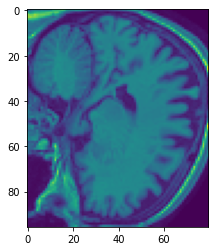

In [14]:
plt.imshow(data[255][30])

(array([1.000e+00, 0.000e+00, 3.000e+00, 3.000e+00, 1.000e+00, 5.000e+00,
        3.700e+01, 1.050e+02, 2.230e+02, 2.680e+02, 3.400e+02, 5.440e+02,
        8.800e+02, 1.037e+03, 7.240e+02, 3.300e+02, 5.700e+01, 9.000e+00,
        0.000e+00, 2.000e+00]),
 array([0.01078017, 0.02548071, 0.04018125, 0.05488178, 0.06958232,
        0.08428286, 0.0989834 , 0.11368393, 0.12838447, 0.14308501,
        0.15778554, 0.17248608, 0.18718662, 0.20188715, 0.21658769,
        0.23128823, 0.24598877, 0.2606893 , 0.27538984, 0.29009038,
        0.30479091]),
 <BarContainer object of 20 artists>)

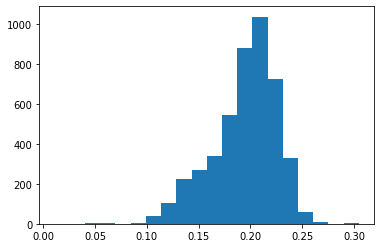

In [15]:
plt.hist(means_, bins=20)

(array([  3.,   3.,   2.,   2.,  12.,  22.,  67., 134., 252., 392., 639.,
        964., 965., 720., 302.,  74.,  11.,   2.,   2.,   1.]),
 array([0.03961949, 0.04984383, 0.06006818, 0.07029252, 0.08051687,
        0.09074121, 0.10096556, 0.1111899 , 0.12141424, 0.13163859,
        0.14186293, 0.15208728, 0.16231162, 0.17253597, 0.18276031,
        0.19298466, 0.203209  , 0.21343335, 0.22365769, 0.23388204,
        0.24410638]),
 <BarContainer object of 20 artists>)

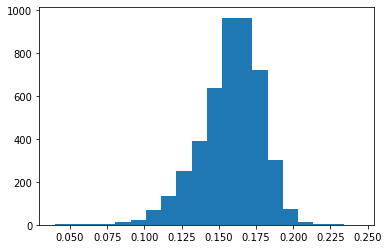

In [16]:
plt.hist(std_, bins=20)

(array([1.000e+00, 0.000e+00, 2.000e+00, 3.000e+00, 5.000e+00, 7.000e+00,
        2.800e+01, 7.000e+01, 2.150e+02, 4.710e+02, 7.750e+02, 1.034e+03,
        9.050e+02, 6.430e+02, 3.030e+02, 8.200e+01, 2.100e+01, 0.000e+00,
        2.000e+00, 2.000e+00]),
 array([0.03357463, 0.07498571, 0.11639679, 0.15780787, 0.19921895,
        0.24063003, 0.28204111, 0.32345219, 0.36486326, 0.40627434,
        0.44768542, 0.4890965 , 0.53050758, 0.57191866, 0.61332974,
        0.65474082, 0.6961519 , 0.73756298, 0.77897405, 0.82038513,
        0.86179621]),
 <BarContainer object of 20 artists>)

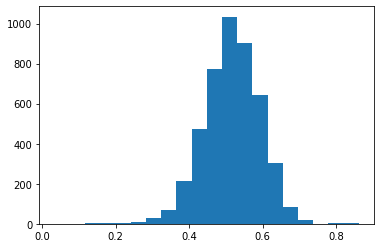

In [17]:
plt.hist(quant_, bins=20)

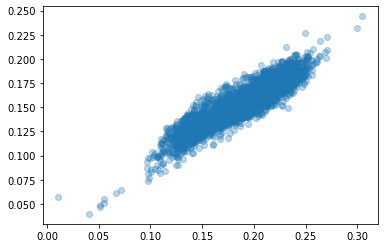

In [18]:
plt.scatter(means_, std_, alpha=.3)

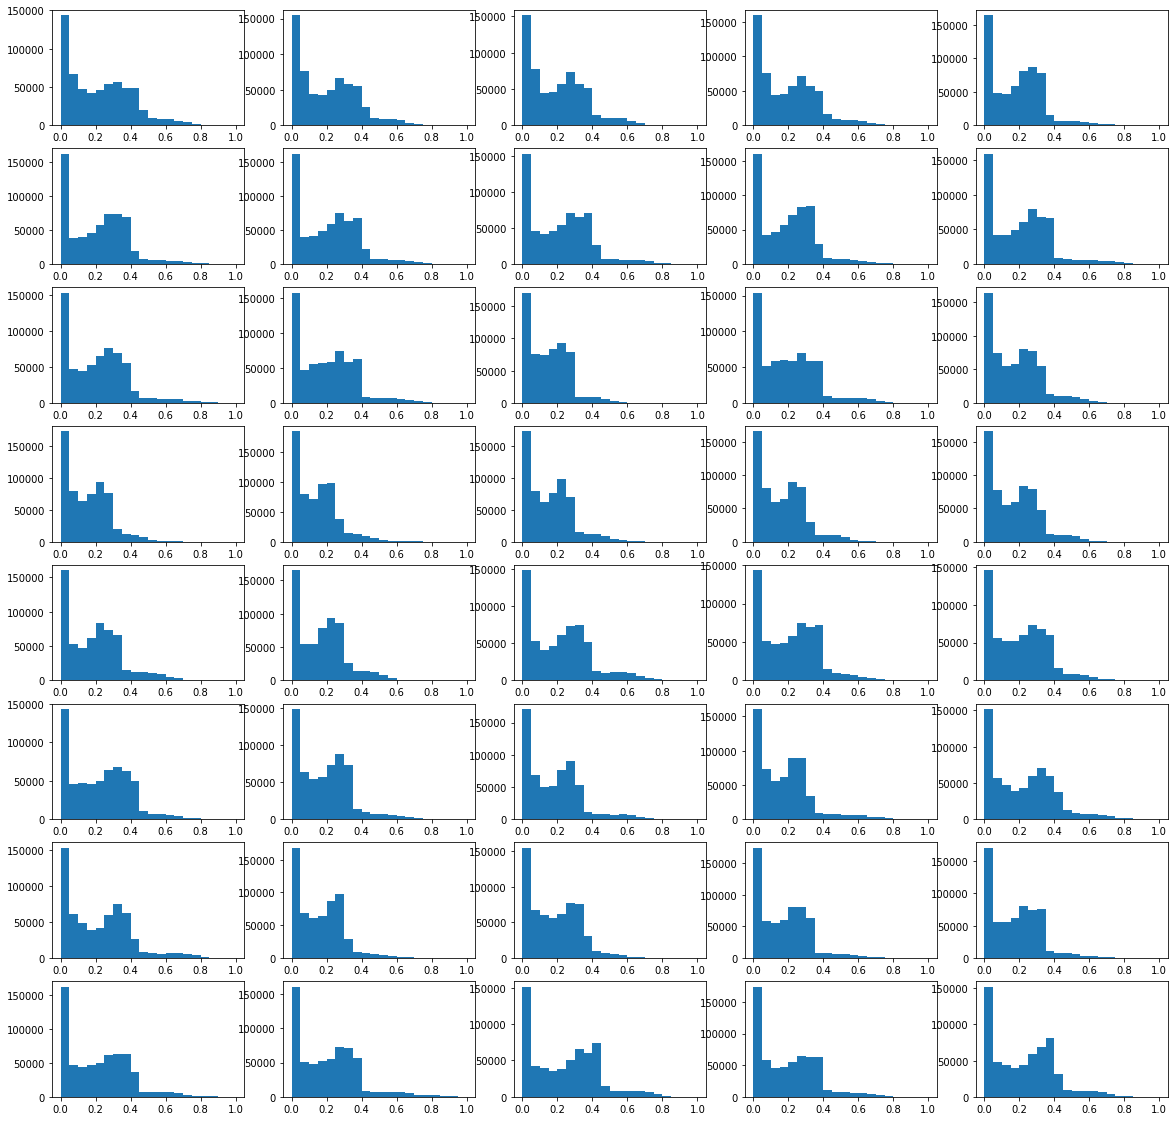

In [19]:
fig, axes = plt.subplots(8,5, figsize=(20,20))

for i in range(40):
    axes[i//5][i%5].hist(np.array(data[i]).reshape(-1), bins=20)

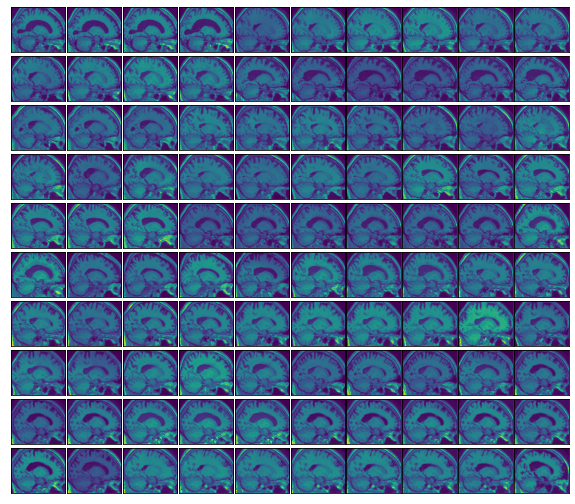

In [20]:
fig, axes = plt.subplots(10,10,figsize=(10,9))
plt.subplots_adjust(wspace=0.03, hspace=0.02)

for i in range(100):
    axes[i//10][i%10].imshow(np.rot90(data[i][30]))
    
for axe in axes:
    for ax in axe:
        ax.set_xticks([])
        ax.set_yticks([])
        
plt.show()

In [21]:
for i in range(n_scans):
    img = data[i]
    quant = np.quantile(img, 0.97)
    data[i] /= quant
    
data[data>1] = 1
data_dict['data'] = data
torch.save(data_dict, 'ADNI_MCI_AD_norm')

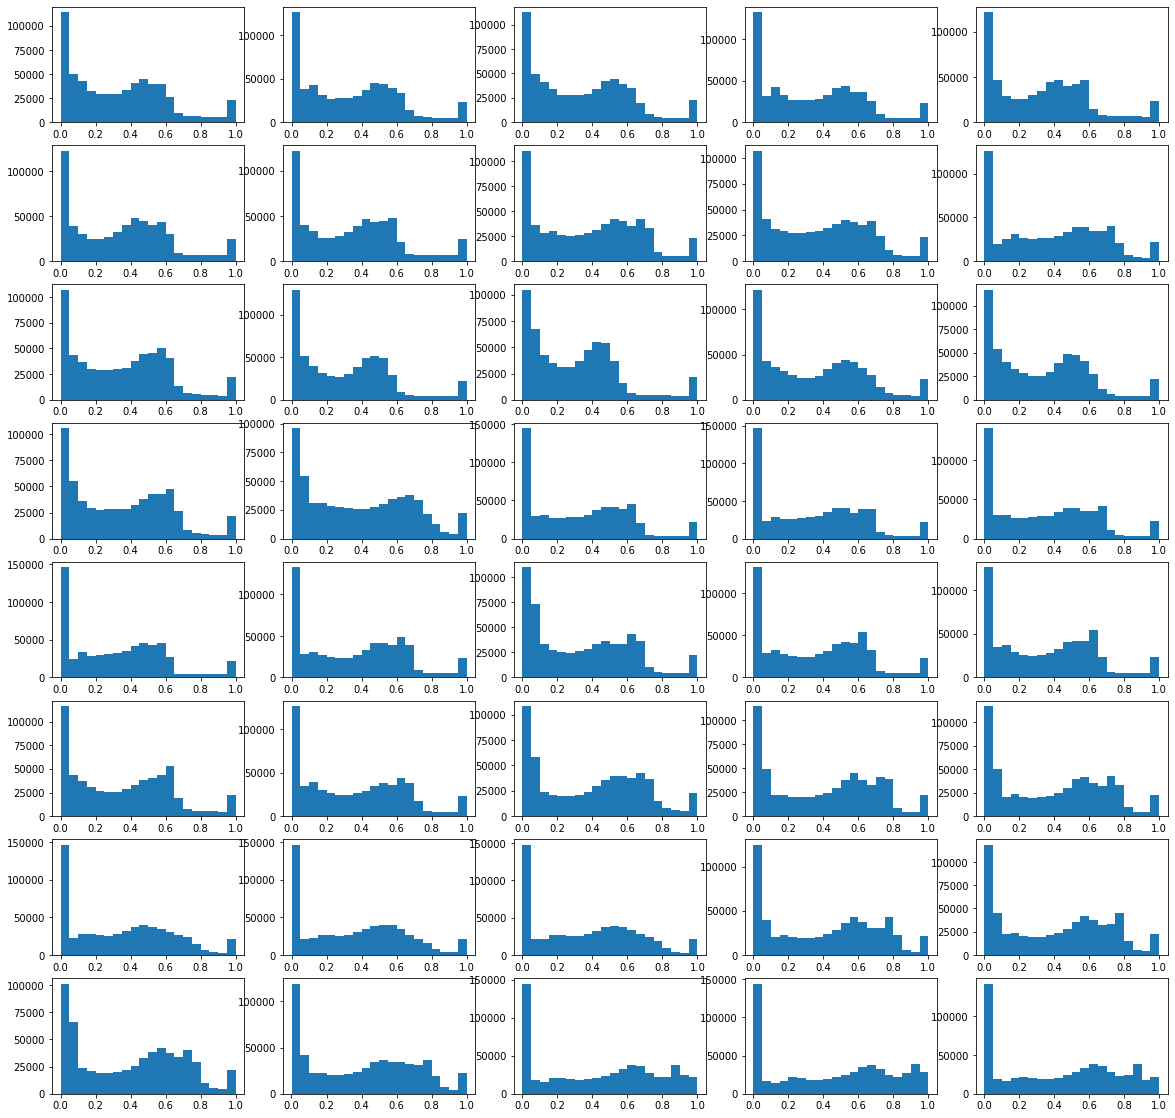

In [115]:
fig, axes = plt.subplots(8,5, figsize=(20,20))

for i in range(40):
    axes[i//5][i%5].hist(np.array(data[i+50]).reshape(-1), bins=20)

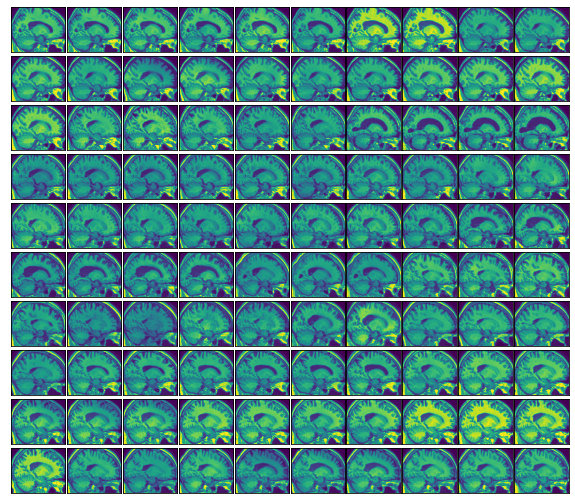

In [38]:
fig, axes = plt.subplots(10,10,figsize=(10,9))
plt.subplots_adjust(wspace=0.03, hspace=0.02)

for i in range(100):
    axes[i//10][i%10].imshow(np.rot90(data[i][30]))
    
for axe in axes:
    for ax in axe:
        ax.set_xticks([])
        ax.set_yticks([])
        
plt.show()

In [39]:
torch_data = torch.load('ADNI_full_norm')

In [41]:
torch_data['labels']

tensor([ 619,  619,  619,  619,  729,  729,  729,  729,  729,  729,  729,  729,
         729,  729,  782,  782,  782,  782,  782,  782,  816,  816,  816,  938,
         938,  938,  938,  954,  954,  954,  954,  955,  955, 1018, 1018, 1018,
        1018])

## Locating the hippocampus

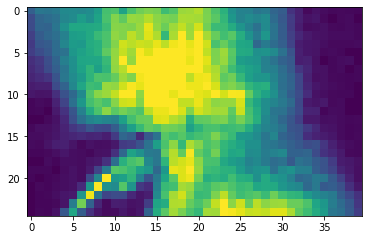

In [17]:
plt.imshow(np.rot90(data[1][0,30:70,15:40]))

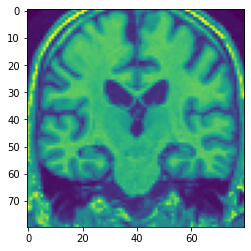

In [72]:
plt.imshow(np.rot90(data[1][:, 44]))

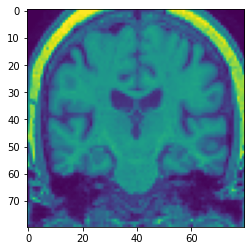

In [79]:
plt.imshow(np.rot90(data[120][:, 44]))

## Add the ventricles and hippocampi volumes

In [8]:
data = torch.load('ADNI_t1')

In [9]:
df = pd.DataFrame()
df['ID'] = data['RID']
df['TIME'] = data['timepoints']
df = df.set_index(['ID', 'TIME'])

In [10]:
columns = ['RID','AGE_vis','MES_MRI_HIPPOCAMPUS_ICV', 'MES_MRI_VENTRICLES_ICV']
data = pd.read_csv('/network/lustre/iss02/aramis/datasets/adni/leaspy/clean/2021-05-25/ADNI_leaspy_ready.csv', 
                   usecols=columns, sep=',', error_bad_lines=False)
data.rename(columns={'RID':'ID', 'AGE_vis':'TIME'}, inplace=True)        
data['TIME'] = [np.around(time, 1) for time in data['TIME']]
data['ID'] = data.index
data = data.set_index(['ID', 'TIME'])

In [11]:
caps = pd.read_csv('/network/lustre/iss02/aramis/datasets/adni/caps/caps_v2021.tsv', sep='\t', error_bad_lines=False)
caps = caps.rename(columns={'participant_id':'ID', 'age':'TIME'})
caps['ID'] = [int(sub[12:]) for sub in caps['ID']]
caps = caps.set_index(['ID','TIME'])
caps = caps.loc[~caps.index.duplicated()]

In [12]:
ventricles = ['t1-volume_group-adni2021_atlas-Neuromorphometrics_ROI-Left-Third-Ventricle_intensity',
              't1-volume_group-adni2021_atlas-Neuromorphometrics_ROI-Right-Third-Ventricle_intensity',
              't1-volume_group-adni2021_atlas-Neuromorphometrics_ROI-Left-Fourth-Ventricle_intensity',
              't1-volume_group-adni2021_atlas-Neuromorphometrics_ROI-Right-Fourth-Ventricle_intensity',
              't1-volume_group-adni2021_atlas-Neuromorphometrics_ROI-Left-Inferior-Lateral-Ventricle_intensity',
              't1-volume_group-adni2021_atlas-Neuromorphometrics_ROI-Right-Inferior-Lateral-Ventricle_intensity',
              't1-volume_group-adni2021_atlas-Neuromorphometrics_ROI-Left-Lateral-Ventricle_intensity',
              't1-volume_group-adni2021_atlas-Neuromorphometrics_ROI-Right-Lateral-Ventricle_intensity',
              't1-volume_group-adni2021_atlas-Neuromorphometrics_ROI-Left-Ventral-Ventricle_intensity',
              't1-volume_group-adni2021_atlas-Neuromorphometrics_ROI-Right-Ventral-Ventricle_intensity']

vents = caps[ventricles].sum(axis=1)
vents.name = 'ventricles'
vents = vents/vents.max()

hippocampi = ['t1-volume_group-adni2021_atlas-Neuromorphometrics_ROI-Left-Hippocampus_intensity',
              't1-volume_group-adni2021_atlas-Neuromorphometrics_ROI-Right-Hippocampus_intensity']


hips = caps[hippocampi].sum(axis=1)
hips.name = 'hippocampus'
hips = hips/hips.max()

In [13]:
vols = df.join(vents).join(hips)
vols.loc[df.index]

ventricles  hippocampus
ID   TIME                         
295  84.8    0.467051     0.749467
     85.3    0.496784     0.754722
     85.8    0.493837     0.753172
     87.0    0.497817     0.742723
     87.8    0.482295     0.726809
...               ...          ...
6575 74.5    0.413605     0.717135
6580 79.9    0.255331     0.629673
     80.9    0.286288     0.623305
6581 74.4    0.457508     0.766824
6803 75.0    0.409512     0.628474

[10053 rows x 2 columns]

In [30]:
vols = vols.dropna()
std_tot = 0
i = 0
for sub in vols.index.get_level_values(0).unique():
    if len(vols.loc[sub]) > 5:
        std_tot += vols.loc[sub].std()['hippocampus']
        i += 1
    if np.isnan(std_tot):
        break
std_tot/i

0.027598116540079164

In [151]:
# This is necessary because there is a duplicated visit somewhere...

vents, hips = [], []

for i in range(data['timepoints'].shape[0]):
    sub = int(data['RID'][i])
    timepoint = float(data['timepoints'][i])
    vent, hip = vols.loc[(sub, timepoint)]
    vents.append(vent)
    hips.append(hip)
    
vents, hips = torch.FloatTensor(vents), torch.FloatTensor(hips)
data['ventricles'], data['hippocampus'] = vents, hips

In [152]:
torch.save(data, 'ADNI_t1')

# FDG-PET

## Loading the tensors

In [16]:
template_data_path = "/network/lustre/iss02/aramis/datasets/adni/caps/caps_v2021/subjects/sub-ADNI006S0498/ses-M00/deeplearning_prepare_data/image_based/pet_linear/sub-ADNI006S0498_ses-M00_task-rest_acq-fdg_pet_space-MNI152NLin2009cSym_desc-Crop_res-1x1x1_suvr-cerebellumPons2_pet.pt"
template_data = torch.load(template_data_path)
#template_data = template_data[:,::2,::2,::2]

In [17]:
template_data.shape

torch.Size([1, 169, 208, 179])

In [18]:
template_data = template_data[:,4:164:2,8:200:2,8:168:2]
template_data.shape

torch.Size([1, 80, 96, 80])

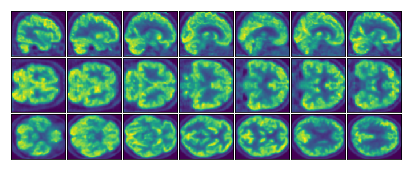

In [19]:
fig, axes = plt.subplots(3,7, figsize=(7,2.75), gridspec_kw={'height_ratios':[.8,.96,.8]})
plt.subplots_adjust(wspace=0.03, hspace=0.02)

for i in range(7):
    axes[2][i].matshow(template_data[0][:,:,20 + 5*i])
    axes[1][i].matshow(template_data[0][:,20 + 5*i])
    axes[0][i].matshow(np.rot90(template_data[0][20 + 5*i]))
    
for axe in axes:
    for ax in axe:
        ax.set_xticks([])
        ax.set_yticks([])

#plt.matshow(template_data[0][:,:,40])
plt.show()

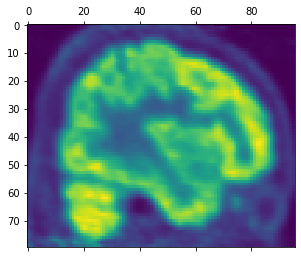

In [20]:
plt.matshow(np.rot90(template_data[0][60]))
plt.show()

In [21]:
caps_info = pd.read_csv('/network/lustre/iss02/aramis/datasets/adni/caps/caps_v2021.tsv', sep='\t', 
                        error_bad_lines=False)[['participant_id', 'session_id', 'age', 'diagnosis', 'MMSE']].set_index(['participant_id','session_id'])

In [ ]:
path_imaging_data = "/network/lustre/iss02/aramis/datasets/adni/caps/caps_v2021/subjects/"

sub_lst = sorted(os.listdir(path_imaging_data))
data_dict = {'data':torch.tensor(template_data), 'timepoints':torch.ones(1), 'labels':torch.IntTensor([1])}

number_of_patients = 3000
i = 0 

for sub in tqdm(sub_lst):
    
    if i == number_of_patients:
        break
        
    sub_id = sub[12:]
    sub_path = path_imaging_data+sub
    ses_lst = sorted(os.listdir(sub_path))
    
    i += 1
    for ses in ses_lst:
        ses_path = os.path.join(sub_path, ses)
        if 'pet_linear' in os.listdir(ses_path):
            filename = 'deeplearning_prepare_data/image_based/pet_linear/' + sub + '_' + ses + '_task-rest_acq-fdg_pet_space-MNI152NLin2009cSym_desc-Crop_res-1x1x1_suvr-cerebellumPons2_pet.pt'
            ses_data_path = os.path.join(ses_path, filename)

            #if (caps_info.loc[(sub,ses)]['diagnosis'] in ['CN']):
            #if 'AD' in caps_info.loc[sub].values:

            # Load the data
            ses_torch = torch.load(ses_data_path)
            if ses_torch.isnan().any() or torch.tensor([caps_info.loc[(sub,ses)]['age']]).isnan():
                continue
            # Subsample
            ses_torch = ses_torch[:,4:164:2,8:200:2,8:168:2]
            # Normalize
            ses_torch = ses_torch/ses_torch.max()

            data_dict['data'] = torch.cat((data_dict['data'], ses_torch.float()))
            data_dict['timepoints'] = torch.cat((data_dict['timepoints'], torch.tensor([caps_info.loc[(sub,ses)]['age']])))
            data_dict['labels'] = torch.cat((data_dict['labels'], torch.tensor([int(sub_id)])))

# Threshold to have a lot of 0 values in the input
mask_threshold = data_dict['data']<(torch.tensor(3e-2))
data_dict['data'][mask_threshold] = 0
        
# Then add the (useless timepointss) and delete the template data
data_dict['data'], data_dict['timepoints'], data_dict['labels'] = data_dict['data'][1:], data_dict['timepoints'][1:], data_dict['labels'][1:]

data_dict

/tmp/ipykernel_472894/2639485350.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data_dict = {'data':torch.tensor(template_data), 'timepoints':torch.ones(1), 'labels':torch.IntTensor([1])}
 79%|███████████████████████████████████████▍          | 1777/2254 [42:00<1:10:13,  8.83s/it]

In [ ]:
print(f"There are {data_dict['data'].shape[0]} visits with a total of {data_dict['data'].shape[1]*data_dict['data'].shape[2]*data_dict['data'].shape[3]} dimentions")

In [ ]:
torch.save(data_dict, '/network/lustre/iss02/aramis/users/benoit.sautydechalon/miccai_2022/ADNI_PET')

### Reorder the ids

In [4]:
data_dict = torch.load('/network/lustre/iss02/aramis/users/benoit.sautydechalon/miccai_2022/ADNI_PET')

In [ ]:
already_seen = []
group = []
idx = -1

for i in range(len(data_dict['labels'])):
    if data_dict['labels'][i] not in already_seen:
        already_seen.append(data_dict['labels'][i])
        idx += 1
    group.append(idx)

In [ ]:
data_dict['RID'] = data_dict['labels']
data_dict['labels'] = torch.tensor(group)

In [ ]:
torch.save(data_dict, '/network/lustre/iss02/aramis/users/benoit.sautydechalon/miccai_2022/ADNI_PET')

## Parse the full dataset to select cohorts with given diagnosis

In [29]:
caps_info.index = [int(sub[12:]) for sub in caps_info.index.get_level_values(0)]

In [10]:
data_dict = torch.load('ADNI_PET')

In [56]:
data_dict_AD = {'data':torch.tensor(template_data), 'timepoints':torch.ones(1), 'labels':torch.IntTensor([1]), 'RID':torch.IntTensor([1])}

for i in range(len(data_dict['labels'])):
    sub = int(data_dict['RID'][i])
    if 'AD' in caps_info.loc[sub].values:
        data_dict_AD['data'] = torch.cat((data_dict_AD['data'], data_dict['data'][i].unsqueeze(0)))
        data_dict_AD['timepoints'] = torch.cat((data_dict_AD['timepoints'], data_dict['timepoints'][i].unsqueeze(0)))
        data_dict_AD['labels'] = torch.cat((data_dict_AD['labels'], data_dict['labels'][i].unsqueeze(0)))
        data_dict_AD['RID'] = torch.cat((data_dict_AD['RID'], data_dict['RID'][i].unsqueeze(0)))
        
# Then delete the template data
data_dict_AD['data'] = data_dict_AD['data'][1:]
data_dict_AD['timepoints'] = data_dict_AD['timepoints'][1:]
data_dict_AD['labels'] = data_dict_AD['labels'][1:]
data_dict_AD['RID'] = data_dict_AD['RID'][1:]

/tmp/ipykernel_261033/450279758.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data_dict_AD = {'data':torch.tensor(template_data), 'timepoints':torch.ones(1), 'labels':torch.IntTensor([1]), 'RID':torch.IntTensor([1])}


In [58]:
torch.save(data_dict_AD, 'ADNI_PET_AD')

In [59]:
data_dict_CN = {'data':torch.tensor(template_data), 'timepoints':torch.ones(1), 'labels':torch.IntTensor([1]), 'RID':torch.IntTensor([1])}

for i in range(len(data_dict['labels'])):
    sub = int(data_dict['RID'][i])
    if 'AD' not in caps_info.loc[sub].values:
        data_dict_CN['data'] = torch.cat((data_dict_CN['data'], data_dict['data'][i].unsqueeze(0)))
        data_dict_CN['timepoints'] = torch.cat((data_dict_CN['timepoints'], data_dict['timepoints'][i].unsqueeze(0)))
        data_dict_CN['labels'] = torch.cat((data_dict_CN['labels'], data_dict['labels'][i].unsqueeze(0)))
        data_dict_CN['RID'] = torch.cat((data_dict_CN['RID'], data_dict['RID'][i].unsqueeze(0)))
        
# Then delete the template data
data_dict_CN['data'] = data_dict_CN['data'][1:]
data_dict_CN['timepoints'] = data_dict_CN['timepoints'][1:]
data_dict_CN['labels'] = data_dict_CN['labels'][1:]
data_dict_CN['RID'] = data_dict_CN['RID'][1:]

/tmp/ipykernel_261033/943327241.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data_dict_CN = {'data':torch.tensor(template_data), 'timepoints':torch.ones(1), 'labels':torch.IntTensor([1]), 'RID':torch.IntTensor([1])}


In [60]:
torch.save(data_dict_CN, 'ADNI_PET_CN')

In [72]:
data_dict = torch.load('ADNI_PET_CN')

In [73]:
already_seen = []
group = []
idx = -1

for i in range(len(data_dict['RID'])):
    if data_dict['RID'][i] not in already_seen:
        already_seen.append(data_dict['RID'][i])
        idx += 1
    group.append(idx)

In [74]:
data_dict['labels'] = torch.tensor(group)

In [75]:
torch.save(data_dict, 'ADNI_PET_CN')

## Tau PET

## Loading the tensors

In [38]:
import nibabel as nib

template_data_path = "/network/lustre/iss02/aramis/datasets/adni/bids/BIDS/sub-ADNI301S6224/ses-M00/pet/sub-ADNI301S6224_ses-M00_task-rest_acq-tau_pet.nii.gz"
template_data = np.array(nib.load(template_data_path).dataobj)
#template_data = template_data[:,::2,::2,::2]

In [40]:
template_data.shape

(128, 128, 47)

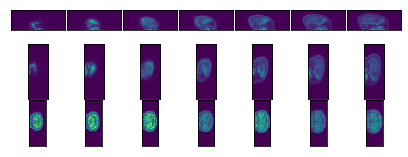

In [43]:
fig, axes = plt.subplots(3,7, figsize=(7,2.75), gridspec_kw={'height_ratios':[.8,.96,.8]})
plt.subplots_adjust(wspace=0.03, hspace=0.02)

for i in range(7):
    axes[2][i].matshow(template_data[:,20 + 2*i])
    axes[1][i].matshow(template_data[20 + 2*i])
    axes[0][i].matshow(np.rot90(template_data[20 + 2*i]))
    
for axe in axes:
    for ax in axe:
        ax.set_xticks([])
        ax.set_yticks([])

#plt.matshow(template_data[0][:,:,40])
plt.show()

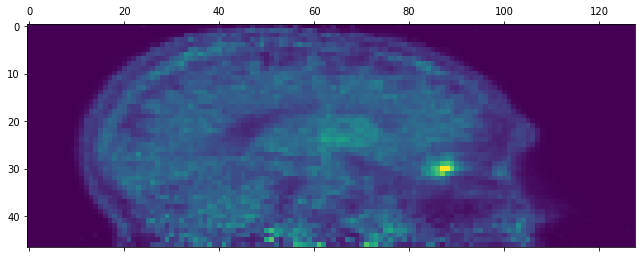

In [46]:
plt.matshow(np.rot90(template_data[50]))
plt.show()

In [21]:
caps_info = pd.read_csv('/network/lustre/iss02/aramis/datasets/adni/caps/caps_v2021.tsv', sep='\t', 
                        error_bad_lines=False)[['participant_id', 'session_id', 'age', 'diagnosis', 'MMSE']].set_index(['participant_id','session_id'])

In [ ]:
path_imaging_data = "/network/lustre/iss02/aramis/datasets/adni/caps/caps_v2021/subjects/"

sub_lst = sorted(os.listdir(path_imaging_data))
data_dict = {'data':torch.tensor(template_data), 'timepoints':torch.ones(1), 'labels':torch.IntTensor([1])}

number_of_patients = 3000
i = 0 

for sub in tqdm(sub_lst):
    
    if i == number_of_patients:
        break
        
    sub_id = sub[12:]
    sub_path = path_imaging_data+sub
    ses_lst = sorted(os.listdir(sub_path))
    
    i += 1
    for ses in ses_lst:
        ses_path = os.path.join(sub_path, ses)
        if 'pet_linear' in os.listdir(ses_path):
            filename = 'deeplearning_prepare_data/image_based/pet_linear/' + sub + '_' + ses + '_task-rest_acq-fdg_pet_space-MNI152NLin2009cSym_desc-Crop_res-1x1x1_suvr-cerebellumPons2_pet.pt'
            ses_data_path = os.path.join(ses_path, filename)

            #if (caps_info.loc[(sub,ses)]['diagnosis'] in ['CN']):
            #if 'AD' in caps_info.loc[sub].values:

            # Load the data
            ses_torch = torch.load(ses_data_path)
            if ses_torch.isnan().any() or torch.tensor([caps_info.loc[(sub,ses)]['age']]).isnan():
                continue
            # Subsample
            ses_torch = ses_torch[:,4:164:2,8:200:2,8:168:2]
            # Normalize
            ses_torch = ses_torch/ses_torch.max()

            data_dict['data'] = torch.cat((data_dict['data'], ses_torch.float()))
            data_dict['timepoints'] = torch.cat((data_dict['timepoints'], torch.tensor([caps_info.loc[(sub,ses)]['age']])))
            data_dict['labels'] = torch.cat((data_dict['labels'], torch.tensor([int(sub_id)])))

# Threshold to have a lot of 0 values in the input
mask_threshold = data_dict['data']<(torch.tensor(3e-2))
data_dict['data'][mask_threshold] = 0
        
# Then add the (useless timepointss) and delete the template data
data_dict['data'], data_dict['timepoints'], data_dict['labels'] = data_dict['data'][1:], data_dict['timepoints'][1:], data_dict['labels'][1:]

data_dict

/tmp/ipykernel_472894/2639485350.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data_dict = {'data':torch.tensor(template_data), 'timepoints':torch.ones(1), 'labels':torch.IntTensor([1])}
 79%|███████████████████████████████████████▍          | 1777/2254 [42:00<1:10:13,  8.83s/it]

In [ ]:
print(f"There are {data_dict['data'].shape[0]} visits with a total of {data_dict['data'].shape[1]*data_dict['data'].shape[2]*data_dict['data'].shape[3]} dimentions")

In [ ]:
torch.save(data_dict, '/network/lustre/iss02/aramis/users/benoit.sautydechalon/miccai_2022/ADNI_PET')

### Reorder the ids

In [4]:
data_dict = torch.load('/network/lustre/iss02/aramis/users/benoit.sautydechalon/miccai_2022/ADNI_PET')

In [ ]:
already_seen = []
group = []
idx = -1

for i in range(len(data_dict['labels'])):
    if data_dict['labels'][i] not in already_seen:
        already_seen.append(data_dict['labels'][i])
        idx += 1
    group.append(idx)

In [ ]:
data_dict['RID'] = data_dict['labels']
data_dict['labels'] = torch.tensor(group)

In [ ]:
torch.save(data_dict, '/network/lustre/iss02/aramis/users/benoit.sautydechalon/miccai_2022/ADNI_PET')